# Pipeline sur sub_01 

In [5]:
import os
import numpy as np
import mne
import borsar

In [6]:
from os import listdir, path
import mne
import matplotlib
import matplotlib.pyplot as plt
#import meegkit
import numpy as np
import pandas as pd
import math
import pyriemann
#import picard
import time
import scipy.io as sio
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch
from mne.channels import find_ch_adjacency
from mne.stats import(f_mway_rm,f_threshold_mway_rm,spatio_temporal_cluster_test)
from mne.preprocessing import artifact_detection
from borsar.utils import get_info, find_index, find_range
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mne.viz import plot_compare_evokeds

In [7]:
def fix_channel_pos(inst):
    '''Scale channel positions to default mne head radius.
    FIXME - add docs'''
    import borsar
    from mne.bem import _fit_sphere

    # get channel positions matrix
    pos = borsar.channels.get_ch_pos(inst)

    # remove channels without positions
    no_pos = np.isnan(pos).any(axis=1) | (pos == 0).any(axis=1)
    pos = pos[~no_pos, :]

    # fit sphere to channel positions
    radius, origin = _fit_sphere(pos)

    default_sphere = 0.095
    scale = radius / default_sphere

    info = get_info(inst)
    for idx, chs in enumerate(info['chs']):
        if chs['kind'] == 2:
            chs['loc'][:3] -= origin
            chs['loc'][:3] /= scale

    return inst

#### Importation des données

In [10]:
path_of_the_directory= "/home/drougui/Downloads/doi_10.5061_dryad.9pf3t8d__v1/Iterated_raw_eegdata_sub01"
print("Files and directories in a specified path:");
for filename in os.listdir(path_of_the_directory):
    f = os.path.join(path_of_the_directory,filename)
    if os.path.isfile(f):
        print(f);

Files and directories in a specified path:
/home/drougui/Downloads/doi_10.5061_dryad.9pf3t8d__v1/Iterated_raw_eegdata_sub01/sub01.cnt


In [5]:
#Conversion des données cnt dans un format "raw" appelé raw_init
raw_init = mne.io.read_raw_cnt(f, 
                               eog=('VEO','HEO'), 
                               preload=True)
print(raw_init.info.ch_names)

Reading 0 ... 1353239  =      0.000 ...  1353.239 secs...
['FP1', 'FPZ', 'FP2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'FZ', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCZ', 'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'CZ', 'C2', 'C4', 'C6', 'T8', 'M1', 'TP7', 'CP5', 'CP3', 'CP1', 'CPZ', 'CP2', 'CP4', 'CP6', 'TP8', 'M2', 'P7', 'P5', 'P3', 'P1', 'PZ', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO5', 'PO3', 'POZ', 'PO4', 'PO6', 'PO8', 'CB1', 'O1', 'OZ', 'O2', 'CB2', 'HEO', 'VEO']


In [9]:
raw_init.__dict__

#mne.channels.make_standard_montage('standard_1020')

#get_positions(raw_init)

#mne.channels.get_builtin_montages()

#raw_mont = mne.channels.make_standard_montage('standard_1020', 
                                  # head_size='auto')

#updated_mont = raw.get_montage()

#raw.set_montage('standard_1020')

#mne.channels.make_dig_montage(ch_pos=raw_init.__dict__, nasion=None, lpa=None, rpa=None, hsp=None, hpi=None, coord_frame='unknown')

<DigMontage | 0 extras (headshape), 0 HPIs, 0 fiducials, 20 channels>

4 duplicate electrode labels found:
T7/T3, T8/T4, P7/T5, P8/T6
Plotting 90 unique labels.
Creating RawArray with float64 data, n_channels=90, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


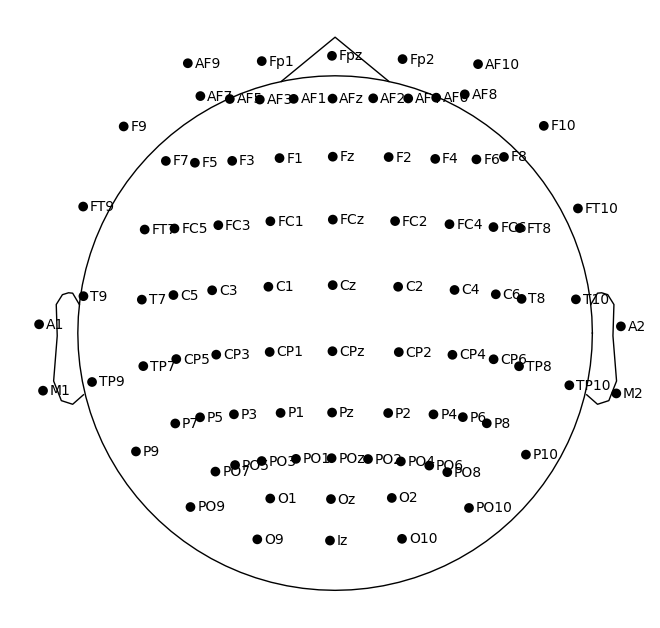

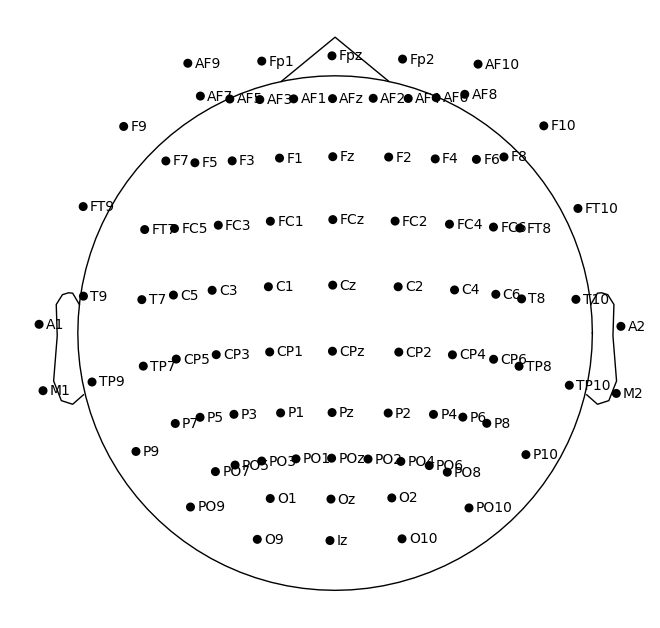

In [21]:
mont1020 = mne.channels.make_standard_montage('standard_1020')
mont1020.plot();

In [35]:
raw_init.set_montage(mont1020, on_missing='warn')

/var/folders/8d/q6tbkztj0znc_qc19khqchf40000gn/T/ipykernel_82426/2637827122.py:1: RuntimeWarning: DigMontage is only a subset of info. There are 12 channel positions not present in the DigMontage. The required channels are:

['FP1', 'FPZ', 'FP2', 'FZ', 'FCZ', 'CZ', 'CPZ', 'PZ', 'POZ', 'CB1', 'OZ', 'CB2'].

Consider using inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  raw_init.set_montage(mont1020, on_missing='warn')


<RawCNT | sub01.cnt, 66 x 1353240 (1353.2 s), ~681.5 MB, data loaded>

In [29]:
##localisation des chaînes
#raw = fix_channel_pos(raw_init.copy()) 

COBYLA failed to find a solution: Maximum number of function evaluations has been exceeded.
   Return from subroutine COBYLA because the MAXFUN limit has been reached.


   NFVALS = 1000   F = 9.208967E-02    MAXCV = 0.000000E+00
   X =-1.341606E-01   7.256627E-02   6.357188E-01   5.894552E-01


## Preprocessing

In [30]:
raw = raw_init.copy();

#### Mauvaises chaînes

In [36]:
#trouver des mauvaises chaînes
ssp_projectors = raw.info['projs']
raw.del_proj();
#pas de mauvaises chaînes d'identifiées avec cette fonction

#marquage de PO7 comme mauvaise chaîne
#raw.load_data();
raw.info['bads'].append('PO7');

#### Interpolation

In [37]:
raw.interpolate_bads(reset_bads=True)

Interpolating bad channels
    Automatic origin fit: head of radius 95.5 mm
Computing interpolation matrix from 63 sensor positions


ValueError: array must not contain infs or NaNs

#### Artefacts

In [ ]:
#tentative de suppression des artefacts liés au battement de coeur
"""ecg_epochs = mne.preprocessing.create_ecg_epochs(raw)
ecg_epochs.plot_image(combine='mean')""";

Effective window size : 2.048 (s)


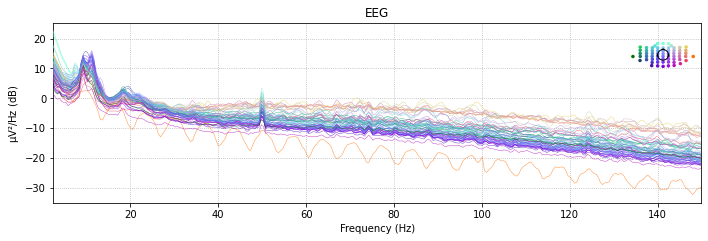

In [14]:
#raw.plot(duration=60, proj=False, n_channels=len(raw.ch_names),remove_dc=False)
#raw.fix
raw.plot_psd(fmin=2., fmax=150);

### Filtrage

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 33001 samples (33.001 sec)

Using matplotlib as 2D backend.
Opening raw-browser...


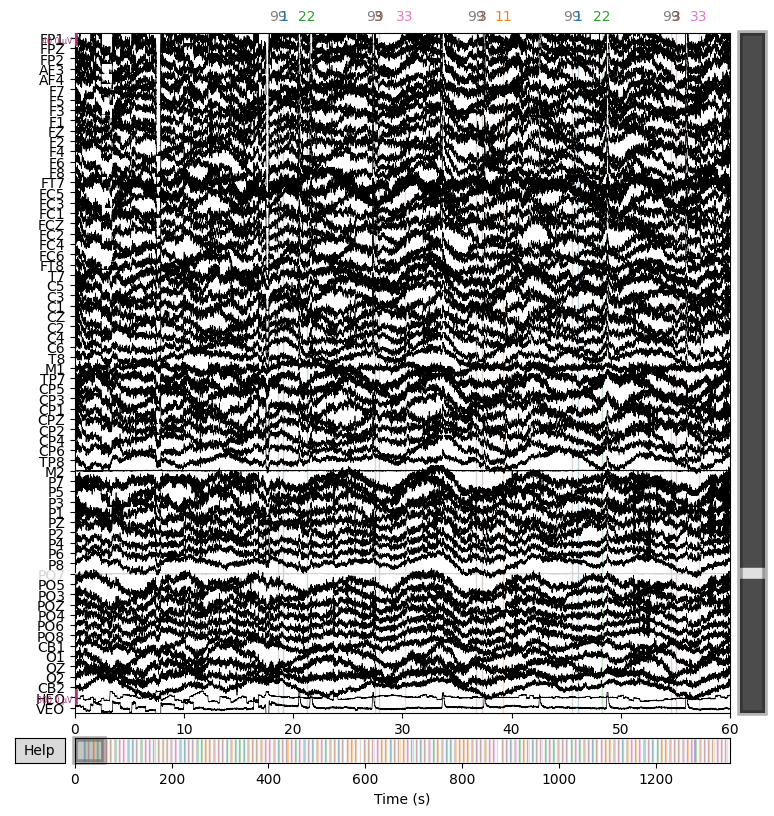

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Filter length: 16501 samples (16.501 sec)

Opening raw-browser...


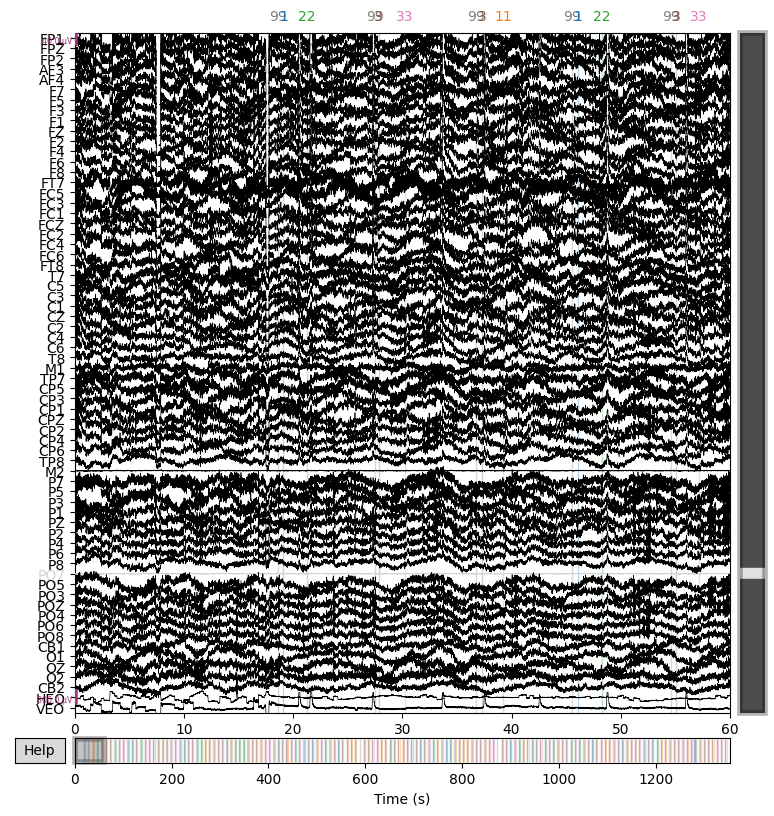

In [15]:
#Highpass filter

for cutoff in (0.1, 0.2):
    raw_highpass = raw.copy().filter(l_freq=cutoff, h_freq=None)
    with mne.viz.use_browser_backend('matplotlib'):
        fig = raw_highpass.plot(duration=60, proj=False, n_channels=len(raw.ch_names), remove_dc=False);
    fig.subplots_adjust(top=0.9);
    fig.suptitle('High-pass filtered at {} Hz'.format(cutoff), size='xx-large',
                 weight='bold');
#push dans raw
raw = raw_highpass

In [16]:
#Notch filter
raw_notch = raw.copy().notch_filter(freqs = 50, notch_widths=7)

Setting up band-stop filter from 46 - 54 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 46.00
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 45.75 Hz)
- Upper passband edge: 54.00 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 54.25 Hz)
- Filter length: 6601 samples (6.601 sec)



Opening raw-browser...


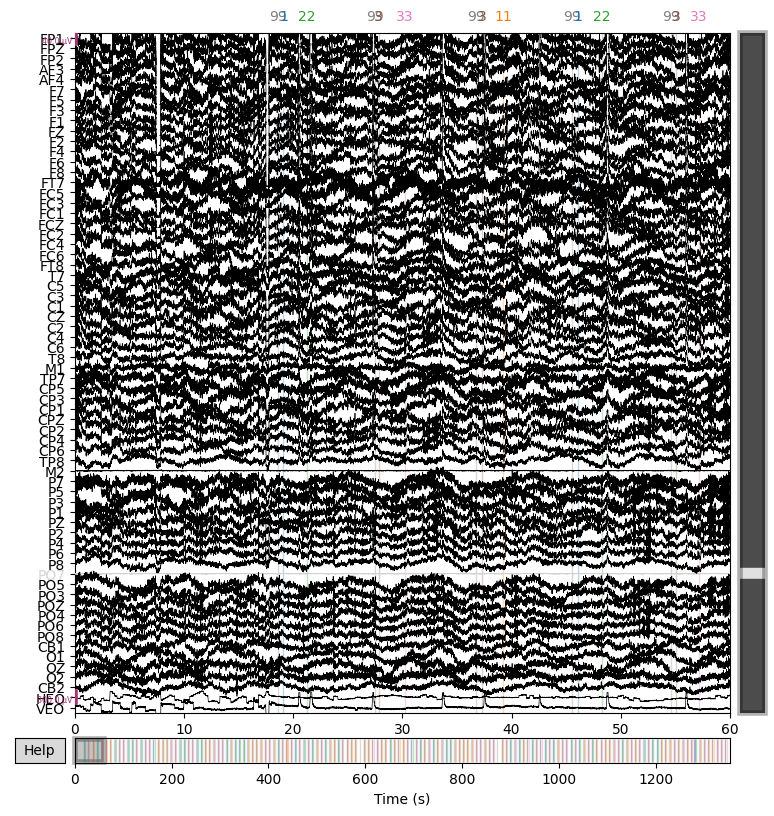

Effective window size : 2.048 (s)


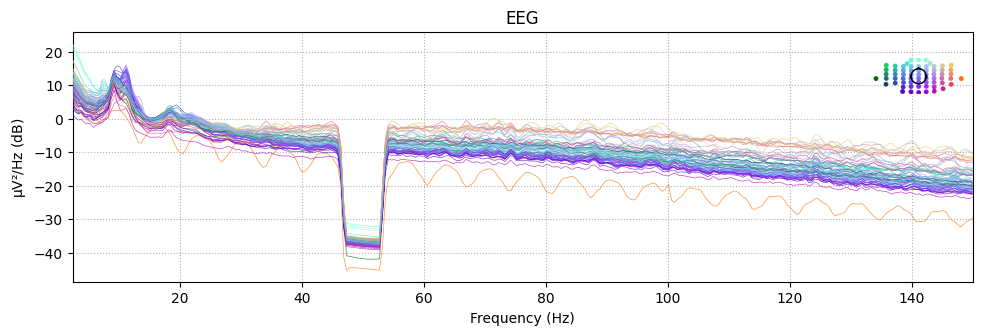

In [17]:
raw_notch.plot(duration=60, proj=False, n_channels=len(raw.ch_names), remove_dc=False);

#push dans raw
raw = raw_notch
raw.plot_psd(fmin=2., fmax=150);

### ICA

Filtering to remove slow drifts -- redondant avec filtrage highpass ?


In [ ]:
#filt_raw = raw.copy().filter(l_freq=1., h_freq=None);
"""A high-pass filter with 1 Hz cutoff frequency is recommended. 
However, because filtering is a linear operation, the ICA solution found from the filtered signal
can be applied to the unfiltered signal (see [2] for more information), 
so we’ll keep a copy of the unfiltered Raw object around so we can apply the ICA solution to it later.""";

In [ ]:
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs,
                               corrmap)

#EEG_ica = EEG_interp.copy()
rank1 = mne.compute_rank(EEG_raw) 
#rank2 = mne.compute_rank(EEG_interp)
Rank = min(rank1['eeg'], rank2["eeg"]) #correction erreurs dans compute rank


#set up ICA
ica = ICA(n_components=Rank, max_iter='auto', random_state=97)
ica.fit(filt_raw)
ica

#plot_sources will show the time series of the ICs
ica.plot_sources(raw, show_scrollbars=False);

#scalp fiel distribution of each component
ica.plot_components();

#### EOG channel to select ICA components

In [ ]:
ica.exclude = []
# find which ICs match the EOG pattern
eog_indices, eog_scores = ica.find_bads_eog(raw)
ica.exclude = eog_indices

# barplot of ICA component "EOG match" scores
ica.plot_scores(eog_scores)

# plot diagnostics
ica.plot_properties(raw, picks=eog_indices)

# plot ICs applied to raw data, with EOG matches highlighted
ica.plot_sources(raw, show_scrollbars=False)

# plot ICs applied to the averaged EOG epochs, with EOG matches highlighted
ica.plot_sources(eog_evoked)

#### Rereference aux mastoïdes M1 et M2

In [ ]:
#Rereference to M1 + M2
raw.set_eeg_reference(ref_channels=['M1','M2'])
raw.plot(duration=60, proj=False, n_channels=len(raw.ch_names),
         remove_dc=False);

## Epoching Continuous Data

In [ ]:
#je ne comprends pas si cette section a un effect -> les marqueurs devraient s'afficher mais ne le font pas

#BS: Quand tu créé ton dictionnaire d'évènements, tu associe tes annotations "1", "11", "22", "33"... à 
#des identifiants (1,2,3,4,5,6,7). C'est ceux que tu peux voir en faisant "print(event_dict)". Et toi ce 
#que tu veux changer après c'est pas forcément l'identifiant, c'est le nom associé. Donc il faut réutiliser les
#identifiants (1 à 7) et leur associer un nouveau nom. 
#Toi en fait tu ne conservais plus que les identifiants 1 et 3 (les deux seuls inclus dans [1-7]) que tu remplaçais
#par les noms "10" et "30". Donc tu perdais la majorité de tes évènements. Et en plus tu donnais deux fois le nom 10,
#pour les réponses et pour les feedbacks.
#Là normalement ça devrait fonctionner... ^^

events_from_annot, event_dict = mne.events_from_annotations(raw)
print(event_dict)
mapping = {1:"Rep_10", 2:"FB_0", 3:"FB_10", 4:"stop", 5:"Rep_30", 6:"FB_20", 7:"start"}

annot_from_events = mne.annotations_from_events(
    events=events_from_annot, 
    event_desc=mapping, 
    sfreq=raw.info['sfreq'],
    orig_time=raw.info['meas_date'])
raw.set_annotations(annot_from_events)

mne.set_log_level(verbose=False)

#print(raw.annotations.description)

#raw.annotations.description.count("Rep_10")
#print(len(raw.annotations))

#for i in range(len(raw.annotations)):
    #raw.annotation.description
    
    
    #print(raw.annotations[i])
    
#raw.plot_psd(fmin=2., fmax=150);

In [ ]:
#La tu prends l'ensemble des évènement pour créer des épochs. Tu as 448 évènements au total et tu crées 448 epochs (en plus tu réutilises les anciennes valeurs de event_dict et annotations)
#Nous on veut sélectionner, grâce aux nouveaux évènements, les moments 'start' où s'affiche le choix possible
#Et ensuite les moments où s'affiche le feedback (soit FB_O, FB_10 ou FB_20) mais dans un jeux de données séparé.
events_from_annot, event_dict = mne.events_from_annotations(raw_notch)
epochs = mne.Epochs(raw, events_from_annot, event_id=event_dict, tmin=-0.2, tmax=1,
                    preload=True)
fig = epochs.plot(events=events_from_annot);


In [ ]:
epochs_choice = epochs['start']

epochs_FB = epochs[['FB_0','FB_10','FB_20']]
epochs_Rep = epochs['Rep_10','Rep_30']
epochs_stop = epochs['stop']

In [ ]:
epochs_choice.average().plot();

Tu obtiens quelque chose de tout à fait normal. Mais il y a plusieurs choses:
- Le tracé qui fait du grand n'importe quoi, si tu cliques dessus tu verras que c'est l'EOG vertical: donc c'est des électrodes mises autour des yeux pour voir quand il y a des clignements etc; Ce n'est pas de l'activité cérébrale. Les amplitudes EOG sont beaucoup plus grandes, et vu qu'elles ne dépendent pas des évèneent (affichage, stimulation) envoyé, si tu les moyennes ça ne donne rien.
- Tu n'as pas du tout pré-traité tes données. Tu as pris les données brutes que tu as découpées et moyennées, donc c'est normal qu'elles soient bruitées. 

In [ ]:
evoked = epochs['start'].average()

In [ ]:
evoked.plot();

In [ ]:
raw.ch_names